# Experimento 4

Hacemos cross-validation dejando uno afuera, usando el algoritmo de machine learning para crear la matris de submuestreo y el algoritmo de optimizacion para reconstruir la imagen con alta resolucion

In [1]:
%pylab inline
import time
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu

Populating the interactive namespace from numpy and matplotlib


## Load DWI

In [2]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
gtab = datas[name]['gtab']

lr_hr_img = DownsampledImage(name, datas[name]['img'], gtab, scale)

img_hr = lr_hr_img.get_hr_img().astype(float)
img_lr = lr_hr_img.get_lr_img().astype(float)

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


## Select VOI


In [17]:
img_shape = img_lr.shape
x0,xf, y0,yf, z0,zf = volume_range_lr = (22, 28, 15, 21, 23, 29)
b0, bf = bval_range = (10,16)
gdirections = lr_hr_img.gtab.bvecs[b0:bf]

# Type and intensiti of noise to apply
SNR, SNR_TYPE = 25, 'gaussian'

#img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf] = (img_hr[2*x0:2*xf, y0, 2*z0:2*zf, b0:bf].max())*np.ones((12,12,12,6))

i_lr = img_lr[x0:xf, y0:yf, z0:zf, b0:bf]
i_hr = img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf]
voi_hr_shape = i_hr.shape
voi_lr_shape = i_lr.shape

## Save VOI selected

In [ ]:
## Save i_hr ##
RES_BASE_FOLDER = './resultados/exp4/'
np.save(RES_BASE_FOLDER+'i_hr', i_hr)
np.save(RES_BASE_FOLDER+'i_lr', i_lr)

('b=2000, G directions =',
 array([[  2.18280000e-02,   8.02420000e-01,  -5.96360000e-01],
        [ -1.54250000e-02,   2.20980000e-01,   9.75160000e-01],
        [ -7.09180000e-01,  -6.31060000e-04,  -7.05030000e-01],
        [ -2.46500000e-01,   1.04300000e-01,  -9.63510000e-01],
        [ -4.83470000e-01,   4.39100000e-01,  -7.57260000e-01],
        [  1.51030000e-01,   9.65230000e-01,   2.13360000e-01]]))

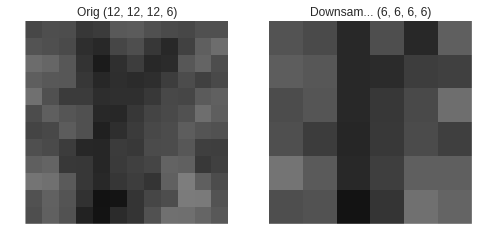

In [4]:
# Show VOI
img_utils._isc(i_hr,i_lr,titles=['Orig '+ str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )
'b=2000, G directions =', gdirections

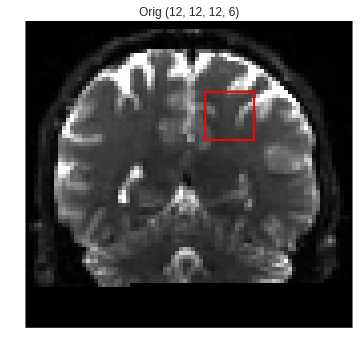

(81, 12, 76) y= 6
HR max,min 989.0 56.3402134135 79.521167049


In [5]:
## Show VOI in HR context
rect_hr = 2*z0, 2*x0, 2*xf-2*x0, 2*zf-2*z0

res=img_utils._iswr(img_hr[:,2*y0:2*yf,:,0],  rect_hr, b=1,title='Orig '+ str(i_hr.shape), vmax=2500)
## For save in fs
# res[1].savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/hardi.pdf')
print 'HR max,min', img_hr[:,:,:,10:16].max(), img_hr[:,:,:,10:16].mean(), np.std(img_hr[:,:,:,10:16])

In [ ]:
## Show VOI in LR context
rect_lr = z0, x0, xf-x0, zf-z0

res =img_utils._iswr(img_lr[:,y0:yf,:,0], rect_lr,b=1, title='Sub muestro '+str(i_lr.shape), vmax=2500)
## For save in fs
# res[1].savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/downsampling.pdf')
print 'LR max,min', img_lr.min(), img_lr.max()
print rect_lr

# Predicting the G downsampling Matrix

## Training set generator

In [24]:
from dipy.sims import phantom

def get_sample_with_snr(number, i_hr, scale, snr, snr_type):
    noised_hr = phantom.add_noise(i_hr, snr=snr, noise_type=snr_type)
    noised_lr = img_utils.downsampling2(noised_hr, scale)
    return noised_hr, noised_lr

def get_sample_maker(i_hr, scale, snr, snr_type):
    return lambda number : get_sample_with_snr(number, i_hr, scale, snr, snr_type)
    
    
def buildT(sample_getter, n_samples):
    noised_hr, noised_lr = sample_getter(0)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr, noised_lr = sample_getter(i)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

## Example of use
#buildT(get_sample_maker(i_hr, scale, snr, snr_type), n_samples)

## Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [51]:
def define_problem(i_lr, i_hr, downsampling_matrix, scale):
    Nx, Ny, Nz, bval = i_hr.shape
    vhrb = Nx*Ny*Nz*bval
    vlr = Nx*Ny*Nz/(scale**3)
      
    Yhr = cvx.Variable(vhrb, 1)
    Yhr.value = i_hr.reshape((vhrb, 1))
    
    Ylr = cvx.Parameter(vlr*bval, 1)
    Ylr.value = i_lr.reshape((vlr*bval, 1))
    
    G = cvx.Parameter(vlr*bval, vhrb)
    G.value = downsampling_matrix

    # Form objective.
    obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr))

    # Create two constraints.
    #constraints = [Yhr >= 0]

    # Form and solve problem.
    prob = cvx.Problem(obj)
    return prob, Yhr, Ylr, G

## Example of use
#prob, Yhr, Ylr, G= define_problem(i_hr,scale=2, n_samples=6)
#prob.is_dcp()

## Solving the problem and cross-validation (leave one out)

In [65]:
def solveMin(i_lr, i_hr, downsampling_matrix, scale=2):
    prob, Yhr, Ylr, G = define_problem(i_lr, i_hr, downsampling_matrix, scale)
    
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=2100, eps=1.00e-01 )  # Returns the optimal value.
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    # Change dimension of result representation
    A = np.asarray(Yhr.value).reshape(i_hr.shape)
    return A, seg, prob

In [57]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f

n_samples = 3


# Metrics to save
Yhr_norms = []
times = []
dif_norms = []
Ylr_norms = []
optimal_vals = []


#base_folder = RES_BASE_FOLDER
base_folder = None

for i in range(0, n_samples):
    print 'Leaving out: #', i
    
    ### Aca mandar shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    lr_samples, hr_samples = buildT(get_sample_maker(i_hr, scale=2, snr=50, snr_type=SNR_TYPE), n_samples) #lr, hr

    # Build downsampling matrix
    regr, hr_train , lr_train, hr_test, lr_test = e1f.train(hr_samples, lr_samples)
    regr.coef_ = csr_matrix(regr.coef_)
    
    # Reshape the one that left out to validate
    i_lr = lr_test.reshape(voi_lr_shape)
    i_hr = hr_test.reshape(voi_hr_shape)
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20 
    A, seg, prob = solveMin(i_lr, i_hr, regr.coef_, scale=2)
    
    # Keep parameters
    dif_norm = np.linalg.norm(i_hr-A)
    Yhr_norm = np.linalg.norm(A)
    Ylr_norm = np.linalg.norm(i_lr)
    
    dif_norms.append(dif_norm)
    Yhr_norms.append(Yhr_norm)
    Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = folder + '_lo' + str(i)
        np.save(name, A)
        print 'saved A in: ', name + str('.npy')
        
# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(total_sec//60)+"'", str(total_sec%60)+ '"'

# Persist results
if base_folder is not None:
    np.save(base_folder+ 'Yhr_norms', Yhr_norms)
    np.save(base_folder+ 'Ylr_norms', Ylr_norms)
    np.save(base_folder+ 'dif_norms', dif_norms)
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)



Leaving out: # 0
Training set_training.shape= (10368, 2)  ->target.shape= (1296, 2)
WARN: m less than n, problem likely degenerate
--- time of optimization : 6' 33'' ---
--- status: optimal_inaccurate optimal value 1442.45756111

Leaving out: # 1
Training set_training.shape= (10368, 2)  ->target.shape= (1296, 2)
WARN: m less than n, problem likely degenerate
--- time of optimization : 6' 24'' ---
--- status: optimal_inaccurate optimal value 1444.20927445

Leaving out: # 2
Training set_training.shape= (10368, 2)  ->target.shape= (1296, 2)
WARN: m less than n, problem likely degenerate
--- time of optimization : 6' 56'' ---
--- status: optimal_inaccurate optimal value 1385.31878098

 === TOTAL TIME : 19.0' 53.6201729774"


# Mean and standar desviation of the cross validation

In [ ]:
print "Yhr_norms"
print Yhr_norms, np.array(Yhr_norms).mean(), '+/-', np.std(Yhr_norms)

print "Ylr_norms"
print Ylr_norms, np.array(Ylr_norms).mean(), '+/-', np.std(Ylr_norms)

print "dif_norms"
print dif_norms, np.array(dif_norms).mean(), '+/-', np.std(dif_norms)

print "optimal_vals"
print optimal_vals, np.array(optimal_vals).mean(), '+/-', np.std(optimal_vals)

print "times"
print times, np.array(times).mean(), '+/-', np.std(times)


times
[393.0912199020386, 384.42198395729065, 416.1069691181183] 397.873390992 +/- 13.3700272105


(6, 37)

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

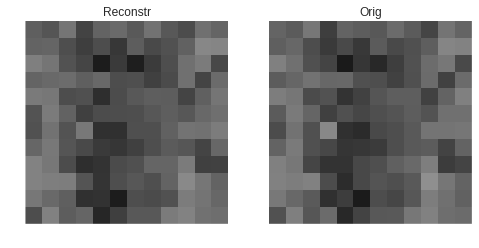

In [74]:
A.min(), A.max(), i_hr.min(), i_hr.max()
img_utils._isc(A, i_hr, vmax=500, vmin=-55, titles=['Reconstr', 'Orig'])